This is an example of how one can use the tree-based model for speed predictions. The model used here is the seasonal date-time variant of the XGBoost model developed in the paper by by Rao,P., Kim, E., Smestad, B.B., Asbjørnslett, B.E. and Bhattacharyya, A. (2021) *Predicting vessel speed in Arctic without knowing ice conditions using AIS data and decision trees*, Maritime Transport Research. 

We will use a synteticly generated test voyage for demonstration. To learn how to prepare a dataset for this prediction, visit the model_implementation notebook. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
ais_df = pd.read_csv('datasets/Test_voyage.csv')
ais_df.head()

,sog,latitude,longitude,Daylight,Route,Port_Distance,Strait_Distance,Oblast_Distance,Vilkitsky_Distance,season
0,0.5,71.279938,72.091477,0.0,1,1.002142,511.853165,640.587551,1143.806917,1
1,0.3,71.279958,72.091318,0.0,1,0.999975,511.847653,640.584542,1143.808515,1
2,0.0,71.279983,72.091218,0.0,1,0.999645,511.844253,640.581280,1143.808422,1
3,0.1,71.279965,72.091088,0.0,1,0.995028,511.839501,640.582636,1143.812832,1
4,1.1,71.279463,72.091212,0.0,1,0.957254,511.840613,640.638493,1143.854917,1


Except sog, these are the features that the machine-learning model will use in order to generate predictions. Please note that any test set must have these features in the same order in order to generate a valid prediction. 

The model developed during the study has its weight saved in a pickel.dat file in the models folder. In order to reconstruct the model from this file, we use the pickle module.

In [3]:
import pickle
xgb_model_loaded = pickle.load(open('models/pima.pickle.dat', "rb"))

[22:48:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Once the model is loaded, we can begin the prediction process. To begin, we seperate the 'sog' column from the test set. We will use this later to measure the accuracy of our predictions.

In [4]:
test_y = ais_df.sog
test_x = ais_df.drop('sog', axis = 1)

Now, we use the model loaded from the pickle.dat file to begin predicting. This is performed via the predict() in the xgboost module. This function returns a list of predictions.

Upon generating predictions, we can now compare the predicted values with the actual values. The metrics used in this case are the Mean-Absolute-Error and the R2-Score.



In [5]:
from sklearn.metrics import r2_score,mean_absolute_error

y_pred = xgb_model_loaded.predict(test_x)
print(r2_score(test_y,y_pred),mean_absolute_error(test_y,y_pred))

0.17953902945822642 2.4861311773482657


The scores generated are well within the expected values of the model. To visualise the accuracy, we can generate a speed-distance plot of the voyage. Through this plot we can identify the regions in which our predictions behave differently.

To create the speed-distance plot, we generate a list named 'distance' which measures the distance covered by the vessel upto that point in the voyage. We then plot the result using the matplotlib library.

In [6]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
def lat_long_dist(lati1,long1,lati2,long2):
    R = 6373.0
    lat1 = radians(lati1)
    lon1 = radians(long1)
    lat2 = radians(lati2)
    lon2 = radians(long2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [7]:
distance = [0]
c = 0

for i in range(1,len(test_x)):
    distance.append(distance[c] + lat_long_dist(test_x.loc[i-1, 'latitude'],test_x.loc[i-1, 'longitude'],test_x.loc[i, 'latitude'],test_x.loc[i, 'longitude']))
    c = c + 1

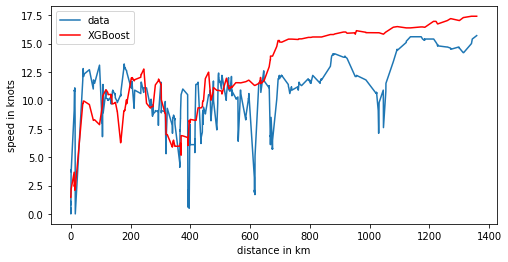

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,4))
plt.xlabel("distance in km")
plt.ylabel("speed in knots")
plt.plot(distance,test_y, label = "data")
plt.plot(distance,y_pred,color = 'r',label = "XGBoost")
plt.legend()
plt.show()